In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json
from math import floor
from itertools import groupby
from tqdm.notebook import tqdm
from multiprocess import Pool
from copy import deepcopy

import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [2]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

In [3]:
def read_files_v2(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    #print(name)
    culling_factor = od()
    #print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

def read_tuple_files(tpl):
    if tpl[1]["heat"]:
        return {
            "cool": read_files_v2(tpl[0]),
            "heat": read_files_v2(tpl[1])
        }

def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in reversed(cool["S"]):
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift
    return {"S": result, "L": heat["L"], "D": heat["D"], "R": heat["R"]}

def calc_hc(st, T):

    fe = mp.mpf(1.0) * np.array([e for e, S in st['S'].items()])
    fS = mp.mpf(1.0) * np.array([S for e, S in st['S'].items()])

    exp = np.frompyfunc(mp.exp, 1, 1)
    w = exp(fS - fe / T)

    Z = w.sum()
    E = (w * fe).sum()
    E_sq = (w * fe * fe).sum()
    E_qr = (w * fe * fe * fe * fe).sum()
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))

def calc_P(st, T):
    fe = mp.mpf(1.0) * np.array([e for e, S in st['S'].items()])
    fS = mp.mpf(1.0) * np.array([S for e, S in st['S'].items()])

    exp = np.frompyfunc(mp.exp, 1, 1)
    w = exp(fS - fe / T)
    Z = w.sum()
    return w / Z


In [4]:
cool = [
    {
        "q": 3,
        "D": 1.962,
        "L": L,
        "R" : 131072,
        "nSteps" : 10,
        "seed" : 0,
        "heat": False
    } for L in [8, 12, 20, 24, 32]
]

heat = deepcopy(cool)
for i, x in enumerate(heat):
    heat[i]["heat"] = True

parameters = []
for x in tqdm(zip(cool, heat)):
    parameters.append(read_tuple_files(x))
for i, x in enumerate(tqdm(parameters)):
    parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


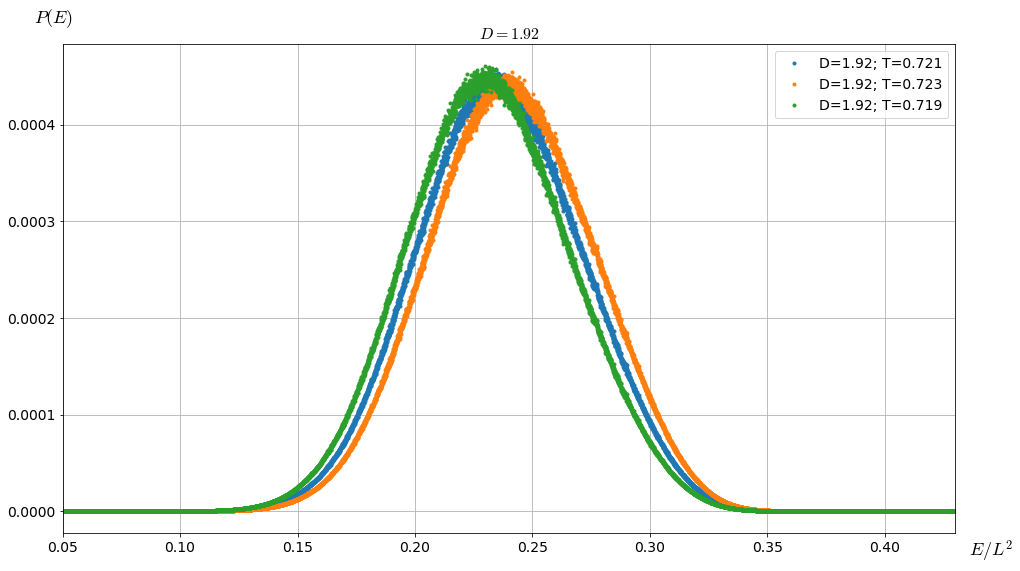

In [52]:

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

ax.set_xlim([0.05, 0.43])
ax.set_ylabel("$P(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)

st = parameters[0]["stitched"]
L = parameters[0]['stitched']['L']
T = 0.721
delta = 0.002
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T) ], 'o', markerSize = 3, label = 'D={}; T={}'.format(st["D"], T))
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T + delta) ], 'o', markerSize = 3, label = 'D={}; T={}'.format(st["D"], T + delta))
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T - delta) ], 'o', markerSize = 3, label = 'D={}; T={}'.format(st["D"], T - delta))
plt.grid()
plt.legend()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.show()


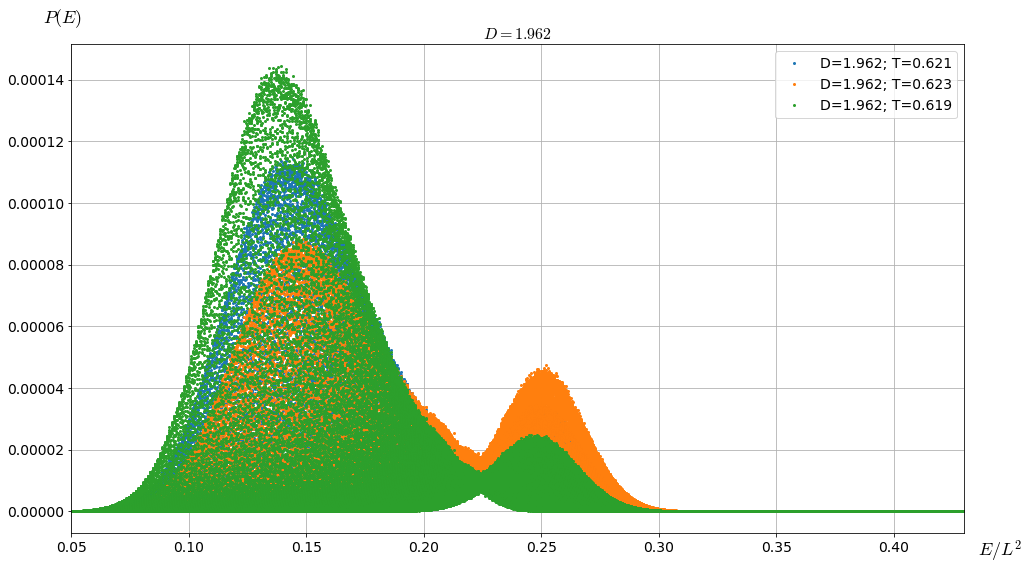

In [54]:

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

ax.set_xlim([0.05, 0.43])
ax.set_ylabel("$P(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)

st = parameters[1]["stitched"]
L = parameters[1]['stitched']['L']
T = 0.621
delta = 0.002
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T) ], 'o', markerSize = 2, label = 'D={}; T={}'.format(st["D"], T))
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T + delta) ], 'o', markerSize = 2, label = 'D={}; T={}'.format(st["D"], T + delta))
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T - delta) ], 'o', markerSize = 2, label = 'D={}; T={}'.format(st["D"], T - delta))
plt.grid()
plt.legend()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.show()


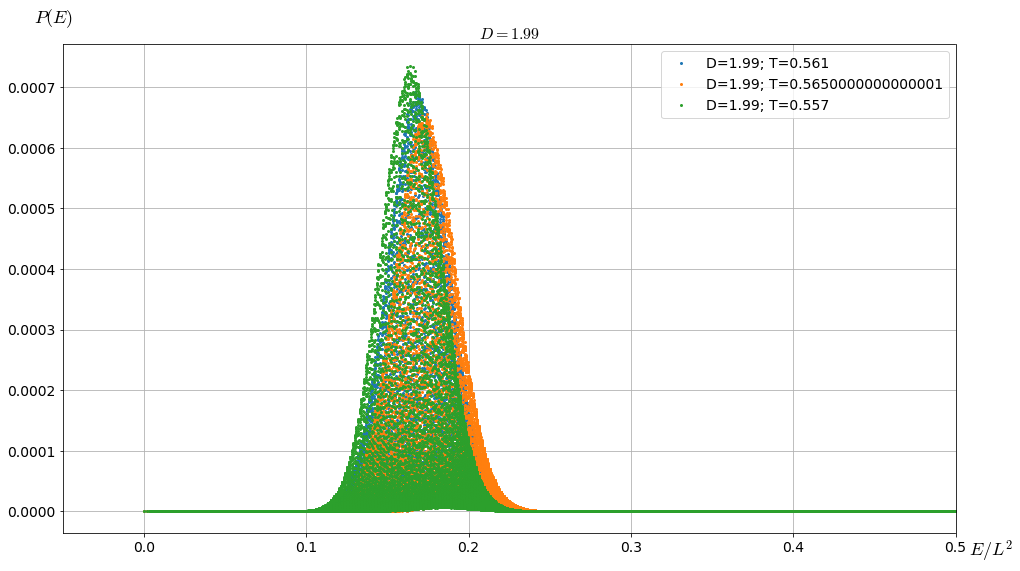

In [57]:

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

ax.set_xlim([-0.05, 0.5])
ax.set_ylabel("$P(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)

st = parameters[2]["stitched"]
L = parameters[2]['stitched']['L']
T = 0.561
delta = 0.004
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T) ], 'o', markerSize = 2, label = 'D={}; T={}'.format(st["D"], T))
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T + delta) ], 'o', markerSize = 2, label = 'D={}; T={}'.format(st["D"], T + delta))
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T - delta) ], 'o', markerSize = 2, label = 'D={}; T={}'.format(st["D"], T - delta))

plt.grid()
plt.legend()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.show()


No handles with labels found to put in legend.


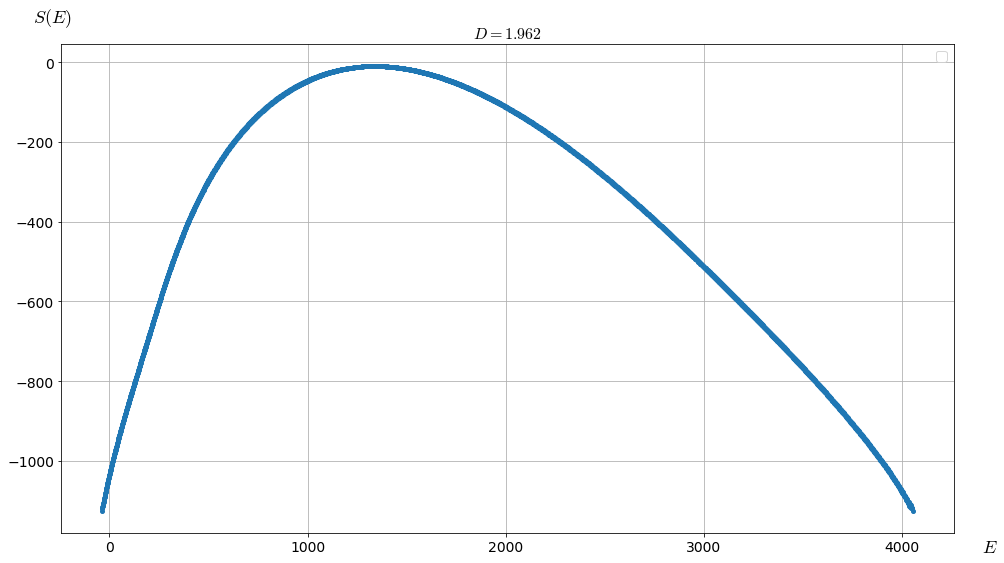

In [97]:

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

#ax.set_xlim([0.05, 0.5])
ax.set_ylabel("$S(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E$", fontsize=18)

i = 0
st = parameters[i]["stitched"]
L = parameters[i]['stitched']['L']
#T = 0.657
a = -200
b = 5000
plt.plot([e for e, S in M.items() if e < b and e > a], [S for e, S in M.items() if e < b and e > a], '-o', markerSize = 4)#, label = 'T={}'.format(T))
plt.grid()
plt.legend()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.show()


In [131]:
parameters[4]["stitched"]["L"]

32

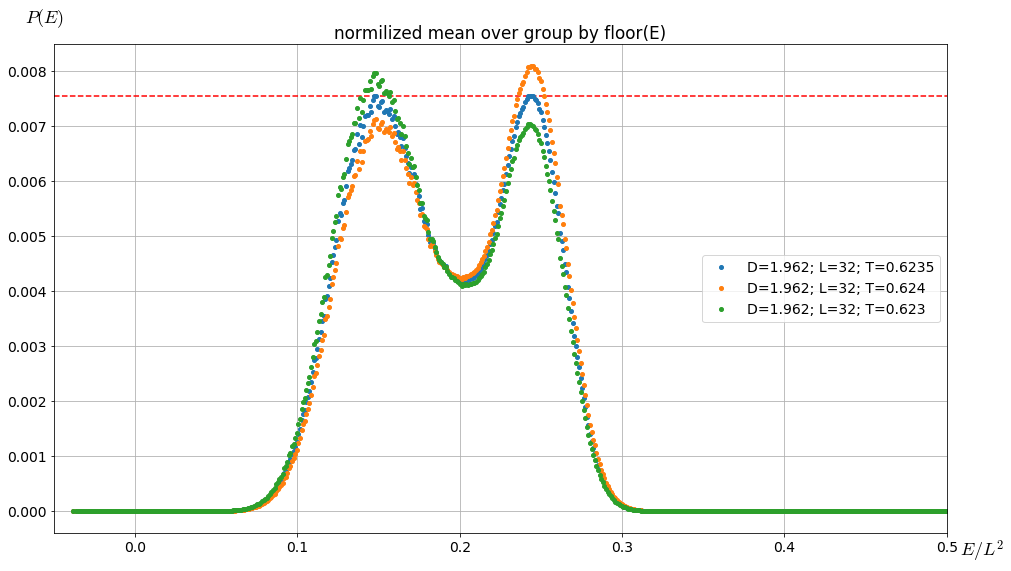

In [149]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

ax.set_xlim([-0.05, 0.5])
ax.set_ylabel("$P(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)

#for x in tqdm(parameters):
x = parameters[4]
st = x["stitched"]
L = x["stitched"]['L']
D = x["stitched"]['D']

T = 0.6235

P = od(zip([e for e, S in st['S'].items()], calc_P(st, T)))
M = od()
for key, group in groupby(P, lambda x: floor(x)):
    M[key] = np.mean([P[x] for x in group])


normalize = np.sum([w for e, w in M.items()])

plt.axhline(y=max([w for e, w in M.items()]) / normalize, color='r', linestyle='--')

plt.plot([e / (L * L) for e, S in M.items()], [w / normalize for e, w in M.items()],
         'o', markerSize = 4, label = 'D={}; L={}; T={}'.format(D, L, T))

T = 0.624

P = od(zip([e for e, S in st['S'].items()], calc_P(st, T)))
M = od()
for key, group in groupby(P, lambda x: floor(x)):
    M[key] = np.mean([P[x] for x in group])


normalize = np.sum([w for e, w in M.items()])

#plt.axhline(y=max([w for e, w in M.items()]) / normalize, color='r', linestyle='-')

plt.plot([e / (L * L) for e, S in M.items()], [w / normalize for e, w in M.items()],
         'o', markerSize = 4, label = 'D={}; L={}; T={}'.format(D, L, T))

T = 0.623

P = od(zip([e for e, S in st['S'].items()], calc_P(st, T)))
M = od()
for key, group in groupby(P, lambda x: floor(x)):
    M[key] = np.mean([P[x] for x in group])


normalize = np.sum([w for e, w in M.items()])

#plt.axhline(y=max([w for e, w in M.items()]) / normalize, color='r', linestyle='-')

plt.plot([e / (L * L) for e, S in M.items()], [w / normalize for e, w in M.items()],
         'o', markerSize = 4, label = 'D={}; L={}; T={}'.format(D, L, T))

plt.title('normilized mean over group by floor(E)')
plt.grid()
plt.legend()
#plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.show()


Left peak: L=8, E=-1, E/L^2=-0.015625
Right peak: L=8, E=19, E/L^2=0.296875


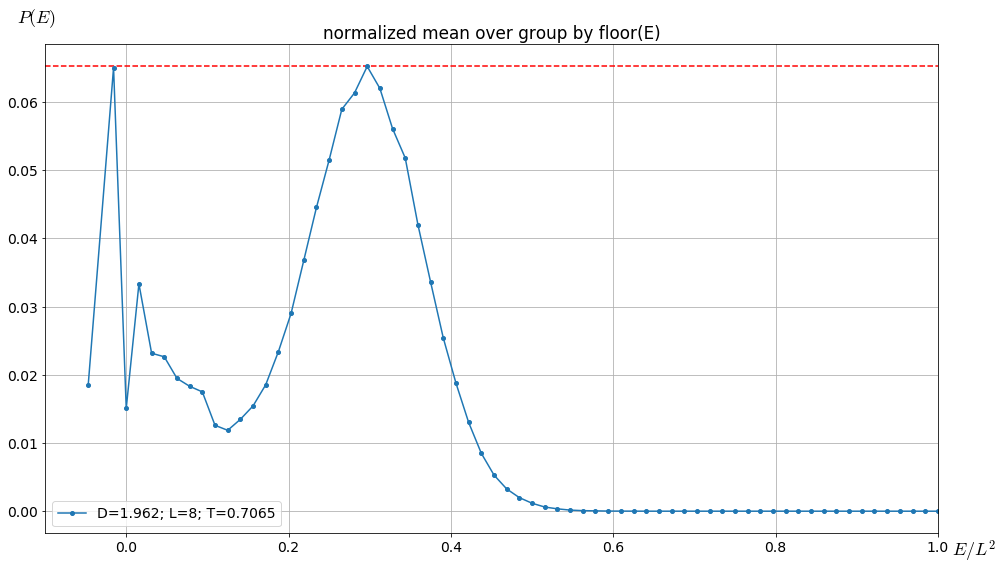

In [8]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

ax.set_xlim([-0.1, 1.0])
ax.set_ylabel("$P(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)

i = 0
T = [0.7065, 0.6287, 0.626, 0.6252, 0.6235][i]
x = parameters[i]
st = x["stitched"]
L = x["stitched"]['L']
D = x["stitched"]['D']

P = od(zip([e for e, S in st['S'].items()], calc_P(st, T)))
M = od()
for key, group in groupby(P, lambda x: floor(x)):
    M[key] = np.mean([P[x] for x in group])

normalize = np.sum([w for e, w in M.items()])

left = [(e, w) for e, w in M.items() if e / (L * L) < 0.2]
left_peak = np.argmax([w for e, w in left])
print("Left peak: L={}, E={}, E/L^2={}".format(L, left[left_peak][0], left[left_peak][0] / (L * L)))

right = [(e, w) for e, w in M.items() if e / (L * L) > 0.2]
right_peak = np.argmax([w for e, w in right])
print("Right peak: L={}, E={}, E/L^2={}".format(L, right[right_peak][0], right[right_peak][0] / (L * L)))


plt.axhline(y=max([w for e, w in M.items()]) / normalize, color='r', linestyle='--')

plt.plot([e / (L * L) for e, S in M.items()], [w / normalize for e, w in M.items()],
         '-o', markerSize = 4, label = 'D={}; L={}; T={}'.format(D, L, T))

plt.title('normalized mean over group by floor(E)')
#plt.ylim([0, 0.03])
plt.grid()
plt.legend()
#plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.show()


Left peak: L=8, E=-1, E/L^2=-0.015625
Right peak: L=8, E=19, E/L^2=0.296875
Left peak: L=12, E=11, E/L^2=0.0763888888888889
Right peak: L=12, E=35, E/L^2=0.24305555555555555
Left peak: L=20, E=49, E/L^2=0.1225
Right peak: L=20, E=99, E/L^2=0.2475
Left peak: L=24, E=82, E/L^2=0.1423611111111111
Right peak: L=24, E=143, E/L^2=0.2482638888888889
Left peak: L=32, E=152, E/L^2=0.1484375
Right peak: L=32, E=248, E/L^2=0.2421875


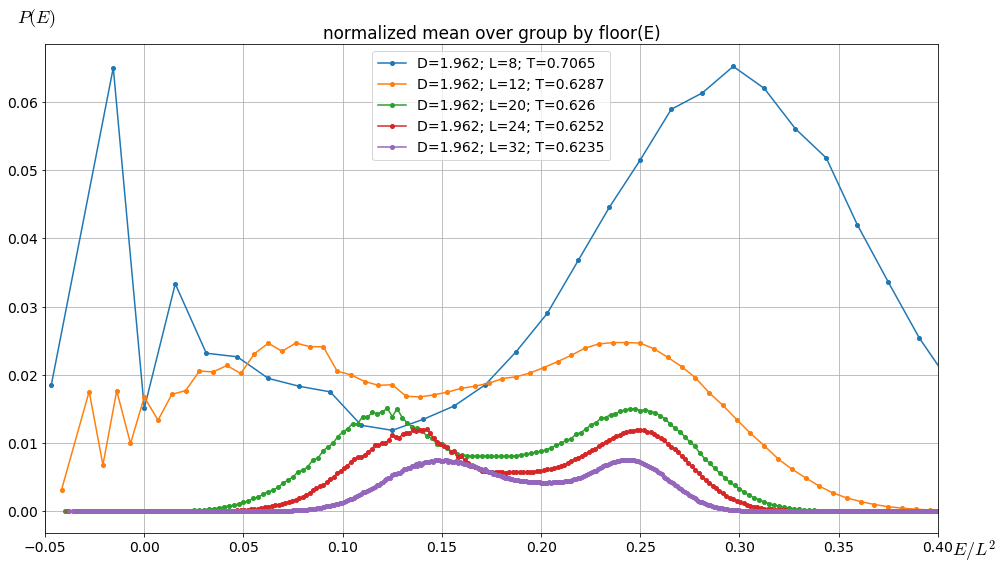

In [9]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

ax.set_xlim([-0.05, 0.4])
ax.set_ylabel("$P(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)



for T, x in zip([0.7065, 0.6287, 0.626, 0.6252, 0.6235], parameters):
    st = x["stitched"]
    L = x["stitched"]['L']
    D = x["stitched"]['D']

    P = od(zip([e for e, S in st['S'].items()], calc_P(st, T)))
    M = od()
    for key, group in groupby(P, lambda x: floor(x)):
        M[key] = np.mean([P[x] for x in group])

    normalize = np.sum([w for e, w in M.items()])
    
    left = [(e, w) for e, w in M.items() if e / (L * L) < 0.2]
    left_peak = np.argmax([w for e, w in left])
    print("Left peak: L={}, E={}, E/L^2={}".format(L, left[left_peak][0], left[left_peak][0] / (L * L)))

    right = [(e, w) for e, w in M.items() if e / (L * L) > 0.2]
    right_peak = np.argmax([w for e, w in right])
    print("Right peak: L={}, E={}, E/L^2={}".format(L, right[right_peak][0], right[right_peak][0] / (L * L)))

    plt.plot([e / (L * L) for e, S in M.items()], [w / normalize for e, w in M.items()],
             '-o', markerSize = 4, label = 'D={}; L={}; T={}'.format(D, L, T))

plt.title('normalized mean over group by floor(E)')
#plt.ylim([0, 0.03])
plt.grid()
plt.legend()
#plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.show()


In [ ]:

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.yaxis.set_label_coords(-0.01, 1.03)
ax.xaxis.set_label_coords(1.04, -0.01)

ax.set_xlim([-0.05, 0.5])
ax.set_ylabel("$P(E)$", rotation=0, fontsize=18)
ax.set_xlabel("$E/L^2$", fontsize=18)

st = parameters[0]["stitched"]
L = parameters[0]['stitched']['L']
T = 0.657
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T) ], 'o', markerSize = 4, label = 'D={}; T={}'.format(T, st["D"]))

st = parameters[1]["stitched"]
L = parameters[1]['stitched']['L']
T = 0.621
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T) ], 'o', markerSize = 4, label = 'D={}; T={}'.format(T, st["D"]))

st = parameters[2]["stitched"]
L = parameters[2]['stitched']['L']
T = 0.550
plt.plot([e / (L * L) for e, S in st['S'].items()], [ w for w in calc_P(st, T) ], 'o', markerSize = 4, label = 'D={}; T={}'.format(T, st["D"]))


plt.grid()
plt.legend()
#plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.show()


In [ ]:
plt.figure(figsize=(16, 9))
plt.plot([e for e, S in x['cool']['culling_factor'].items()], [S for e, S in x['cool']['culling_factor'].items()], 'o')
plt.plot([e for e, S in x['heat']['culling_factor'].items()], [S for e, S in x['heat']['culling_factor'].items()], 'o')

plt.show()